This is a live notebook with experimental code to develop functionality for feature extraction.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json

import scipy.stats as spstats
# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['featured_eeg_prediction_random_forest.ipynb', 'EEG DL.ipynb', 'Untitled.ipynb', 'feature_development.ipynb', 'data', 'data_and_processing_description.ipynb', 'featured_eeg_prediction.ipynb', 'gait_data_exploration.ipynb', 'Analyse_results.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'featured_E4_prediction.ipynb', 'data_investigation_scratch.ipynb', 'Debugging end-to-end.ipynb', 'binxia_cosine_similarity_and_issues.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from predicament.utils.config import DREEM_EEG_CHANNELS
from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import WINDOWED_BASE_PATH


from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from prepare_evaluation_data import load_dataframe_and_config


In [5]:
from predicament.utils.config import E4_CSV_FILES
from predicament.utils.config import E4_FULL_DIRPATHS
E4_FULL_DIRPATHS

{'VG_01': '../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/',
 'VG_03': '../data/CARE_HOME_DATA/./VG03/E4_9921_12_16/',
 'VG_05': '../data/CARE_HOME_DATA/./VG05/E4_9921_13_24/',
 'VG_06': '../data/CARE_HOME_DATA/./VG06/E4_51021_13_33/',
 'VG_07': '../data/CARE_HOME_DATA/./VG07/E4_51021_15_39/',
 'VG_08': '../data/CARE_HOME_DATA/./VG08/E4_71021_10_42/',
 'VG_09': '../data/CARE_HOME_DATA/./VG09/E4_11221_14_46/',
 'VG_10': '../data/CARE_HOME_DATA/./VG10/E4_31221_11_17/',
 'VH_01': '../data/CARE_HOME_DATA/./VH01/E4_61021_11_03/',
 'VH_02': '../data/CARE_HOME_DATA/./VH02/E4_61021_13_59/',
 'VH_03': '../data/CARE_HOME_DATA/./VH03/E4_11221_11_22/'}

## EEG data



In [232]:
subdir = 'dummy'
windowed_data_dir = os.path.join(WINDOWED_BASE_PATH,subdir)

windoweddf, windowedconfig = load_dataframe_and_config(
    windowed_data_dir, 'windowed.csv')

In [278]:
featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featureddf, featuredconfig = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [7]:
n_channels = int(windowedconfig['LOAD']['n_channels'])
channels = json.loads(windowedconfig['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(windowedconfig['LOAD']['participant_list'].replace("'",'"'))
Fs = int(windowedconfig['LOAD']['sample_rate'])
window_size = int(windowedconfig['LOAD']['window_size'])
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")

Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 5


## Gait data

In [ ]:
df = pd.read_csv("../data/other_datasets/uci_multivariate_gait_data/gait.csv")
print(f"df.shape = {df.shape}")
df.head()

In [ ]:
subjects = df['subject'].unique()
conditions = df['condition'].unique()
legs = df['leg'].unique()
joints = df['joint'].unique()
replications = df['replication'].unique()
times = df['time'].unique()
print(f"subjects = {subjects}")
print(f"conditions = {conditions}")
print(f"replications = {replications}")
print(f"joints = {joints}")
print(f"legs = {legs}")
print(f"joints = {joints}")
print(f"times = {times}")



In [ ]:
for subject in subjects:
    subject_df = df[df['subject'] == subject]
    print(f"subject {subject}: has {subject_df.shape[0]} datapoints with {subject_df['time'].max()} time-points")
    
    
    

In [ ]:
s1_c1_r1_df = df[(df['subject'] == 1) &(df['condition'] == 1) &(df['replication'] == 1)]
T = times.size
n_channels = len(legs)*len(joints)

s1_c1_r1_df.head()

In [ ]:
X111 = np.zeros((n_channels, T))
for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
    X111[c,:] = s1_c1_r1_df[(s1_c1_r1_df['leg']==leg)&(s1_c1_r1_df['joint']==joint)]['angle'].to_numpy()


In [ ]:
# the data looks like it has already been smoothed/filtered so
# we will not be applying any filtering to this dataset
fig, axs = plt.subplots(n_channels,1)
for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
    axs[c].plot(times, X111[c,:])


In [ ]:
def get_timeseries(df, subject, condition, replication, legs=None, joints=None):
    if legs is None:
        legs = df['leg'].unique()
    if joints is None:
        joints = df['joint'].unique()
    X = np.zeros((n_channels, T))
    scr_df = df[(df['subject'] == subject) &(df['condition'] == condition) &(df['replication'] == replication)]
    for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
        X[c,:] = scr_df[(scr_df['leg']==leg)&(scr_df['joint']==joint)]['angle'].to_numpy()
    return X

In [ ]:
feature_set = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
     'Energy', 'IQR', 'Entropy',
    'arCoeff', 'Correlation', 'Hurst',
    'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis'#, 'EnergyBands'
    ])
entropy_tol = 1
output_lol = []
scr_cols = ['subject','condition','replication']
for subject, condition, replication, in np.unique(df[scr_cols].values, axis=0):
    # for each unique subject, condition and replication
    X = get_timeseries(df, subject, condition, replication)
    features, feature_names = convert_timeseries_to_features(
        X, feature_set, entropy_tol=entropy_tol, hurst_kind='random_walk')
    output_lol.append(
        np.concatenate(
            ((subject, condition, replication), features)))
all_columns = scr_cols + feature_names
output_df = pd.DataFrame(output_lol,columns=all_columns)
output_df

In [ ]:
output_df.to_csv("../data/other_datasets/uci_multivariate_gait_data/gait_features.csv")

# Aggregate functions

Initially targetted the following list taken from:
Public Domain Dataset for Human Activity Recognition Using Smartphones, (Anguita et al., 2013). 

Most now implemented. No energy bands 18/12/23. No angle between vectors 18/12/23. No SMA, 18/12/23/

| Function	|	Description |
|  :---:	|	:---:  |
| mean	|	Mean value |
| std	|	Standard deviation |
| mad	|	Median absolute value |
| max	|	Largest values in array |
| min	|	Smallest value in array |
| sma	|	Signal magnitude area |
| energy	|	Average sum of the squares |
| iqr	|	Interquartile range |
| entropy	|	Signal Entropy |
| arCoeff	|	Autorregresion coefficients |
| correlation	|	Correlation coefficient |
| maxFreqInd	|	Largest frequency component |
| meanFreq	|	Frequency signal weighted average |
| skewness	|	Frequency signal Skewness |
| kurtosis	|	Frequency signal Kurtosis |
| energyBand	|	Energy of a frequency interval |
| angle	|	Angle between two vectors |

Additional things added:

| Function	|	Description | Sources |
|  :---:	|	:---:  |	:---:  |
| Hurst exponent	|	Limit ratio of spread from random spread | [here](https://www.mdpi.com/1099-4300/23/12/1672) |
| Lyapunov exponent (spectrum)	|	Largest change | [here](https://www.mdpi.com/1099-4300/23/12/1672) |




## Things to explore

THe following list is a live list of things that might potentially relevant.

| Function	|	Description | Sources |
|  :---:	|	:---:  |	:---:  |
| Heart rate variability | A number of choices | |
| Lempev-Ziv Complexity	| LZ complexity of encoding of binary sequence. | TBC |
| Durbin-Watson test statistic | | [here](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic) |


In [ ]:
from predicament.data.features import convert_timeseries_to_features
feature_set = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
     'Energy', 'IQR', 'SampleEntropy',
    'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis'#, 'EnergyBands'
    ])
features111, feature_names = convert_timeseries_to_features(
        X111, feature_set,
        entropy_tol=0.05*(np.mean(np.std(X111,axis=1))))
print(f"features111.shape = {features111.shape}")
print(f"feature_names.shape = {len(feature_names)}")
print(f"feature_names = {feature_names}")


### Lempel-Ziv entropy

In [8]:
# # adapted from:
# # https://stackoverflow.com/questions/46296891/entropy-estimator-based-on-the-lempel-ziv-algorithm-using-python
# import math
# def contains(small, big):
#     try:
#         big.tobytes().index(small.tobytes())//big.itemsize
#         return True
#     except ValueError:
#         return False

# def lempel_ziv_entropy(l):
#     """
#     input
#     -----
#     l - a 1d numpy timeseries array 
#     """
#     n = len(l)
#     sum_gamma = 0

#     for i in range(1, n):
#         sequence = l[:i]

#         for j in range(i+1, n+1):
#             s = l[i:j]
#             if contains(s, sequence) != True:
#                 sum_gamma += len(s)
#                 break

#     ae = 1 / (sum_gamma / n) * math.log(n)
#     return ae




In [ ]:
for c in range(X111.shape[0]):
    ent_raw = lempel_ziv_entropy(X111[c,:])
    print(f"ent_raw = {ent_raw}")
    ent_str = lempel_ziv_entropy(X111[c,:].astype(str))
    print(f"ent_str = {ent_str}")
    

In [215]:
# def quantize_timeseries(seq, amp_min, amp_max, bits_per=8, binarize=True):
#     bins = np.linspace(amp_min, amp_max, 2**bits_per+1)
# #     print(f"bins = {bins}")
#     if bits_per <= 8:
#         quantized = np.empty(seq.size, dtype=np.uint8)
# #     elif bits_per == 32:
# #         quantized = np.empty(seq.size, dtype=np.int32)
#     else:
#         raise ValueError(f'Invalid bits per {bits_per}')
#     for i in range(2**bits_per):
# #         print(f"i = {i}")
# #         print(f"sum((seq >= bins[i])) = {sum((seq >= bins[i]))}")
# #         print(f"sum((seq < bins[i+1])) = {sum((seq < bins[i+1]))}")
#         quantized[(seq >= bins[i]) & (seq < bins[i+1]) ] = i
#     if binarize:
#         unpacked = np.unpackbits(quantized)
#         if bits_per < 8:
#             # by default there are 8 bits per unpacked uint8. We can make this shorter
#             # by removing the big end of each encoding.
#             unpacked =  unpacked.reshape((-1,8))[:,-bits_per:].flatten()
#         return unpacked
#     else:
#         return quantized


# def quantize_multichannel(X, amp_mins, amp_maxes, bits_per=8, binarize=True):
#     bins = np.linspace(amp_mins, amp_maxes, 2**bits_per+1, axis=1)
# #     print(f"bins = {bins}")
#     if bits_per <= 8:
#         quantized = np.empty(X.shape, dtype=np.uint8)
#     else:
#         raise ValueError(f'Invalid bits per {bits_per}')
#     for i in range(2**bits_per):
# #         print(f"i = {i}")
# #         print(f"sum((seq >= bins[i])) = {sum((seq >= bins[i]))}")
# #         print(f"sum((seq < bins[i+1])) = {sum((seq < bins[i+1]))}")
#         quantized[(X >= bins[:,i:i+1]) & (X < bins[:,i+1:i+2]) ] = i
# #     print(f"quantized = {quantized}")
#     if binarize:
#         n_channels = quantized.shape[0]
#         unpacked = np.unpackbits(quantized, axis=1)
#         if bits_per < 8:
#             # by default there are 8 bits per packed quantized vector. We can make this shorter
#             print(f"unpacked.reshape((n_channels, -1,8)).shape = {unpacked.reshape((n_channels, -1,8)).shape}")
#             unpacked =  unpacked.reshape((n_channels, -1,8))[:,:,-bits_per:].reshape((n_channels, -1))
#         return unpacked
#     else:
#         return quantized





In [216]:
data = windoweddf.iloc[:,3:].to_numpy()
N = data.shape[0]
data_tens = data.reshape((N, n_channels, -1))
amp_mins = np.min(data_tens, axis=(0,2))
amp_maxes = np.max(data_tens, axis=(0,2))
i = 0
X = data[i].reshape((n_channels,-1))
X.shape

(5, 1024)

In [217]:
c = 0
X[c,:10]

array([ 1.22301061e-05,  1.49614710e-05,  1.14213779e-05,  3.45616846e-06,
       -6.26382849e-06, -1.50377661e-05, -1.88830396e-05, -1.52666514e-05,
       -6.44693675e-06,  2.96787976e-06])

In [218]:
bits_per = 4
quantized = quantize_timeseries(X[c,:10], amp_mins[c], amp_maxes[c], bits_per=bits_per, binarize=False)
quantized

array([7, 7, 7, 7, 6, 6, 6, 6, 6, 7], dtype=uint8)

In [219]:

unpacked = np.unpackbits(quantized, axis=0)
unpacked

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8)

In [220]:
unpacked.reshape((-1,8))[:,-bits_per:].flatten()

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1], dtype=uint8)

In [221]:
np.unpackbits(np.array([7], dtype=np.uint8))

array([0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8)

In [222]:
print(f"amp_mins = {amp_mins}")
print(f"amp_maxes = {amp_maxes}")

bins = np.linspace(amp_mins, amp_maxes, 3, axis=1)
bins

amp_mins = [-0.000251   -0.0005     -0.00026019 -0.00018061 -0.0005    ]
amp_maxes = [3.14129854e-04 2.99282826e-04 5.53215839e-05 3.44357977e-04
 3.29465171e-04]


array([[-2.51003281e-04,  3.15632868e-05,  3.14129854e-04],
       [-5.00000000e-04, -1.00358587e-04,  2.99282826e-04],
       [-2.60189212e-04, -1.02433814e-04,  5.53215839e-05],
       [-1.80613413e-04,  8.18722820e-05,  3.44357977e-04],
       [-5.00000000e-04, -8.52674144e-05,  3.29465171e-04]])

In [228]:
Q = np.vstack([quantize_timeseries(X[c,:10], amp_mins[c], amp_maxes[c], bits_per=4, binarize=True) for c in range(n_channels)])
Q.shape

(5, 40)

In [229]:
Q[:,:]

array([[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]],
      dtype=uint8)

In [230]:
Qalt = quantize_multichannel(X[:,:10], amp_mins, amp_maxes, bits_per=4, binarize=True)
Qalt.shape

unpacked.reshape((n_channels, -1,8)).shape = (5, 10, 8)


(5, 40)

In [231]:
np.all(Q == Qalt)

True

In [34]:
help(np.unpackbits)

Help on function unpackbits in module numpy:

unpackbits(...)
    unpackbits(a, /, axis=None, count=None, bitorder='big')
    
    Unpacks elements of a uint8 array into a binary-valued output array.
    
    Each element of `a` represents a bit-field that should be unpacked
    into a binary-valued output array. The shape of the output array is
    either 1-D (if `axis` is ``None``) or the same shape as the input
    array with unpacking done along the axis specified.
    
    Parameters
    ----------
    a : ndarray, uint8 type
       Input array.
    axis : int, optional
        The dimension over which bit-unpacking is done.
        ``None`` implies unpacking the flattened array.
    count : int or None, optional
        The number of elements to unpack along `axis`, provided as a way
        of undoing the effect of packing a size that is not a multiple
        of eight. A non-negative number means to only unpack `count`
        bits. A negative number means to trim off that many

In [ ]:
for c in range(X111.shape[0]):
    x = X111[c,:]
    amp_max = x.max()
    amp_min = x.min()
#     print(f"x = {x}")
    quantized =  quantize_timeseries(x, amp_min, amp_max, bits_per=1)
    lze = lempel_ziv_entropy(quantized)
    print(f"lze = {lze}")

In [ ]:
for i in range(3):
    seq = X111[0,0:i]
    print(f"i={i}, seq = {seq}")
    print(f"seq.tobytes() = {seq.tobytes()}")
    print(f"seq.astype(str) = {seq.astype(str)}")
    print(f"seq.astype(str).tobytes() = {seq.astype(str).tobytes()}")
seq = np.array([4.68288097])
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")
seq = np.array([4], dtype=int)
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")
seq = np.array([5], dtype=int)
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")


In [ ]:
def int_to_binary():
    pass

In [ ]:
import numpy as np
np.binary_repr(5, width=8)

In [ ]:
a = np.array([3,6,9], dtype=np.uint8)
np.unpackbits(a)

In [ ]:

np.unpackbits(a).tobytes()

In [ ]:
a = np.array([[3,6,9],[6,9,3],[9,3,6]], dtype=np.uint8)
np.unpackbits(a).shape

In [ ]:
windowed_data = windoweddf.iloc[:,3:].to_numpy()
windowed_data.shape

In [ ]:
# import numpy as np
# from itertools import combinations
# from math import log

# def sample_entropy_stack(timeseries_data, window_size, rs):
#     templates = construct_templates_stack(timeseries_data, window_size)
#     B = get_matches_stack(templates, rs)
    
#     templates_m1 = construct_templates_stack(timeseries_data, window_size + 1)
#     A = get_matches_stack(templates_m1, rs)
    
#     return -np.log(A / B)

# def construct_templates_stack(timeseries_data, m=2):
#     window_shape = (timeseries_data.shape[0], m)
#     return np.squeeze(np.lib.stride_tricks.sliding_window_view(timeseries_data, window_shape))

# def get_matches_stack(templates, rs):
#     num_rows, _, _ = templates.shape
#     indices = np.arange(num_rows)
#     combs = np.array(list(combinations(indices, 2)))
#     matches = np.sum(np.all(np.abs(templates[combs[:, 0]] - templates[combs[:, 1]]) < rs[np.newaxis, :, np.newaxis], axis=2), axis=0)
#     return matches

# # Example usage:
# shape = (3,20)
# timeseries_data_2d = np.sin(np.arange(shape[0])[:,np.newaxis]*np.pi*np.linspace(0,1,shape[1])) + 0.01*np.random.random(shape)

# window_size = 2
# rs = 0.2*np.ones(3)

# result = sample_entropy_stack(timeseries_data_2d, window_size, rs)
# print(result)

In [268]:
featureddf.head()

,part_ID,condition,start time,SampleEntropy0,SampleEntropy1,SampleEntropy2,SampleEntropy3,SampleEntropy4,LempelZivEntropy[b=1][0],LempelZivEntropy[b=1][1],LempelZivEntropy[b=1][2],LempelZivEntropy[b=1][3],LempelZivEntropy[b=1][4],LempelZivComplexity[b=1],LempelZivComplexityAlt[b=1],LempelZivEntropy[b=4][0],LempelZivEntropy[b=4][1],LempelZivEntropy[b=4][2],LempelZivEntropy[b=4][3],LempelZivEntropy[b=4][4]
0,VG_01,0,0,0.787703,0.508855,0.788916,0.755477,0.548672,0.171164,0.090457,0.054047,0.056776,0.151285,5.0,57.0,0.227892,0.193611,0.189826,0.219454,0.245310
1,VG_01,0,0,0.805241,0.532983,0.814717,0.768668,0.554276,0.204601,0.120635,0.054047,0.073568,0.132766,5.0,65.0,0.246267,0.211192,0.203135,0.239977,0.258230
2,VG_01,0,0,0.798022,0.536057,0.834909,0.754516,0.552365,0.182901,0.152977,0.054047,0.096277,0.137846,5.0,63.0,0.248865,0.221569,0.214595,0.237687,0.263325
3,VG_01,0,0,0.800440,0.525794,0.837678,0.723370,0.518803,0.146136,0.119888,0.054047,0.110529,0.126600,5.0,58.0,0.250629,0.218334,0.218350,0.237835,0.245956
4,VG_01,0,0,0.792991,0.529635,0.866467,0.706062,0.517229,0.157744,0.097391,0.054047,0.084557,0.108445,5.0,55.0,0.247442,0.224773,0.219378,0.238946,0.245649


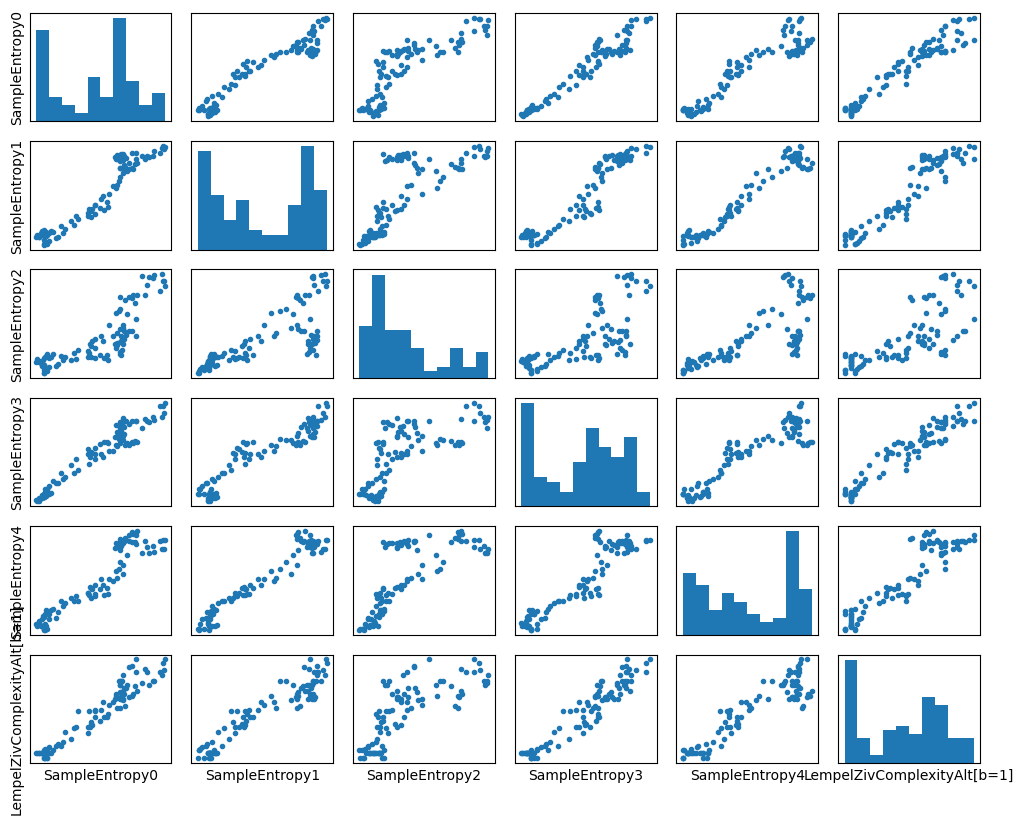

In [269]:
import matplotlib.pyplot as plt

feature_names = list([col for col in featureddf.columns if 'SampleEntropy' in col or 'LempelZivComplexityAlt' in col] )
feature_data = featureddf[feature_names].to_numpy()

N,F = feature_data.shape
fig, axgrid = plt.subplots(F,F, figsize=(10,8))
for i in range(F):
    for j in range(F):
        if i != j:
            axgrid[i,j].scatter(feature_data[:,j],feature_data[:,i], marker='.')
        else:
            axgrid[i,i].hist(feature_data[:,i])
        axgrid[i,j].set_xticks([])
        axgrid[i,j].set_yticks([])
            
        if j == 0:
            axgrid[i,j].set_ylabel(feature_names[i])
        if i == F-1:
            axgrid[i,j].set_xlabel(feature_names[j])
plt.tight_layout()

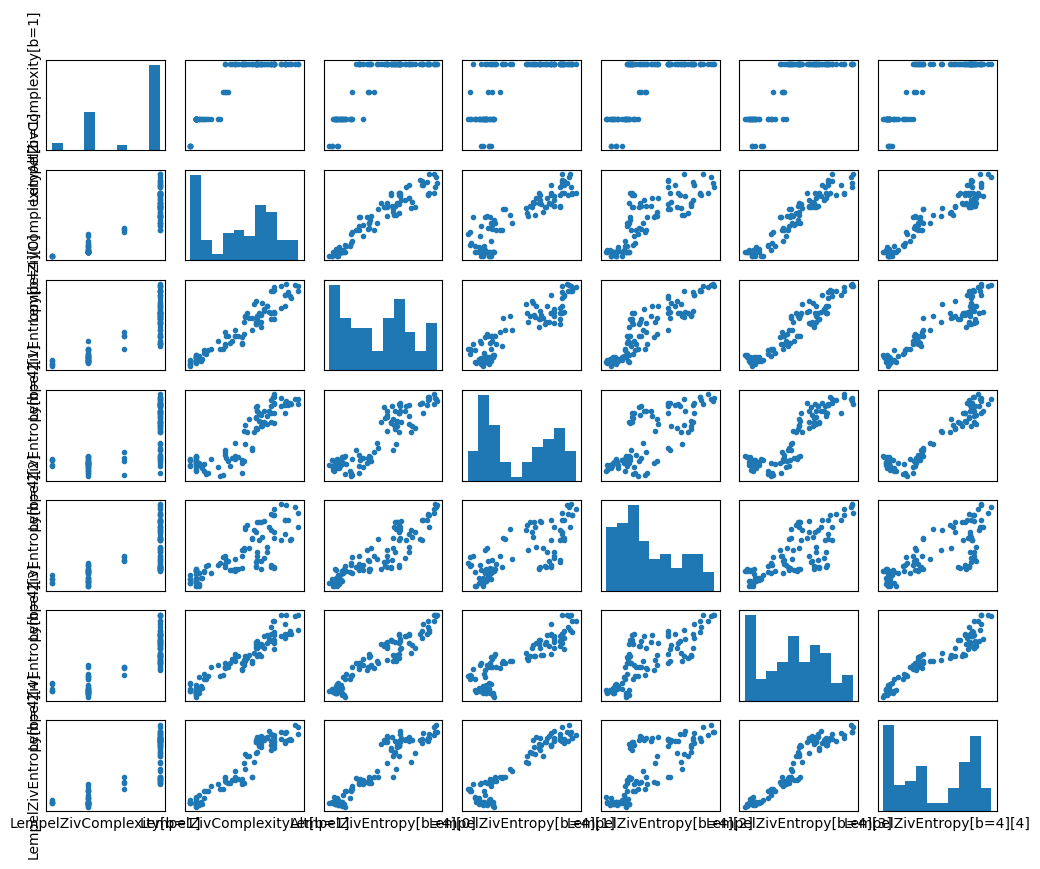

In [273]:
import matplotlib.pyplot as plt

feature_names = list([col for col in featureddf.columns if 'LempelZivEntropy[b=4]' in col or 'LempelZivComplexity' in col] )
feature_data = featureddf[feature_names].to_numpy()

N,F = feature_data.shape
fig, axgrid = plt.subplots(F,F, figsize=(10,8))
for i in range(F):
    for j in range(F):
        if i != j:
            axgrid[i,j].scatter(feature_data[:,j],feature_data[:,i], marker='.')
        else:
            axgrid[i,i].hist(feature_data[:,i])
        axgrid[i,j].set_xticks([])
        axgrid[i,j].set_yticks([])
            
        if j == 0:
            axgrid[i,j].set_ylabel(feature_names[i])
        if i == F-1:
            axgrid[i,j].set_xlabel(feature_names[j])
plt.tight_layout()

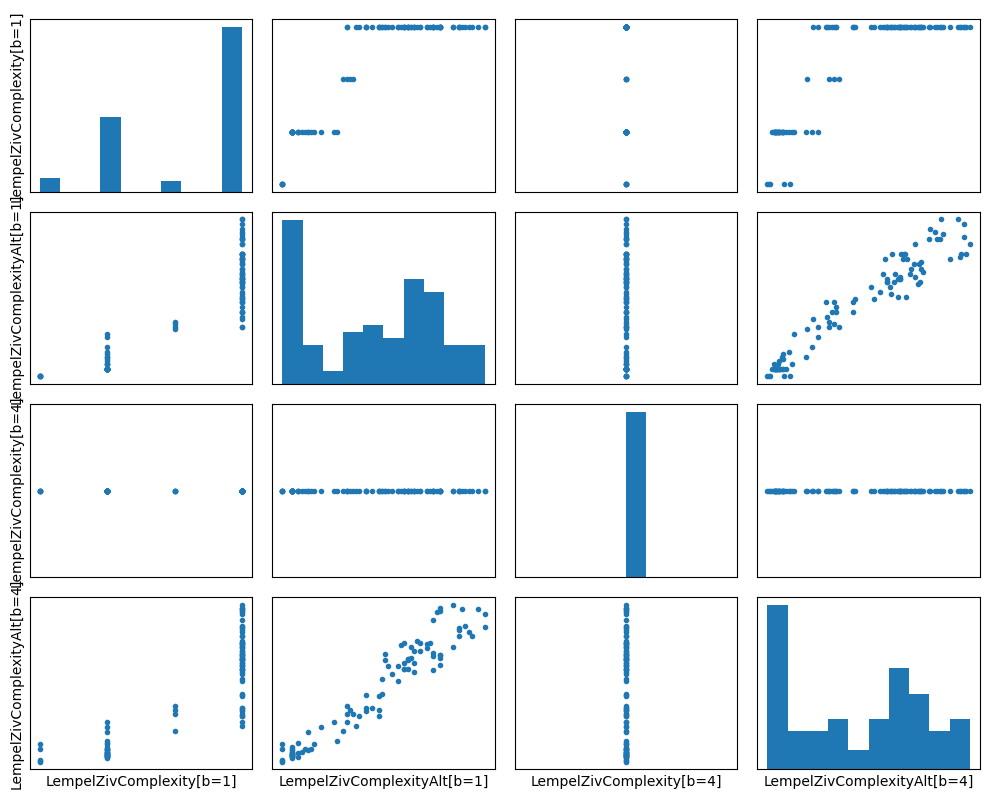

In [275]:
import matplotlib.pyplot as plt

feature_names = list([col for col in featureddf.columns if 'LempelZivComplexity' in col] )
feature_data = featureddf[feature_names].to_numpy()

N,F = feature_data.shape
fig, axgrid = plt.subplots(F,F, figsize=(10,8))
for i in range(F):
    for j in range(F):
        if i != j:
            axgrid[i,j].scatter(feature_data[:,j],feature_data[:,i], marker='.')
        else:
            axgrid[i,i].hist(feature_data[:,i])
        axgrid[i,j].set_xticks([])
        axgrid[i,j].set_yticks([])
            
        if j == 0:
            axgrid[i,j].set_ylabel(feature_names[i])
        if i == F-1:
            axgrid[i,j].set_xlabel(feature_names[j])
plt.tight_layout()

<AxesSubplot:>

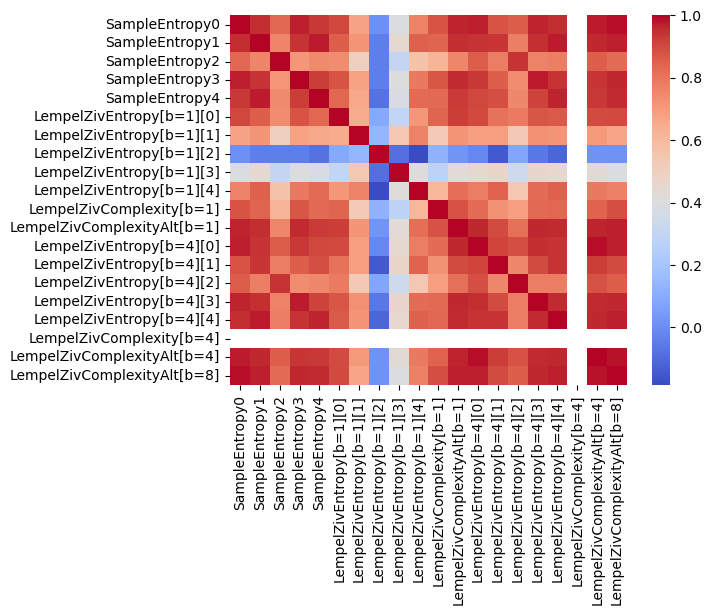

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_corr_matrix = featureddf.iloc[:,3:].corr()
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)